In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.utils as utils
from torchsummary import summary
import torchvision

from albumentations.pytorch import ToTensor
import albumentations as A
from tqdm import tqdm
import random
import numpy as np
import cv2
from collections import OrderedDict

from PIL import Image, ImageDraw, ImageFont

from matplotlib import pyplot as plt
import time
import os

import pickle as pkl
from pathlib import Path

In [22]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Helpers

In [23]:
def show_batch(x,y,shape = None):
    """
    input: 
        x(Tensor[num_images, rows, columns]): images tensor
        y(array): labels
        shape(tuple): (rows,col) 
    output:
        grid of smaple images
    """

    if not shape:
        shape = (int(x.shape[0]**0.5), int(x.shape[0]**0.5))

    fig, axs = plt.subplots(nrows= shape[0], ncols=shape[1], figsize = (12,8))
    index = 0
    for row in axs:
        for ax in row:
            ax.imshow(x[index])
            ax.set_xlabel(y[index], )
            index+=1

    # plt.subplots_adjust(wspace = 0.2, hspace = 0.5) 
    fig.tight_layout()
    plt.show()

In [24]:
with open("chinese_labels","rb") as f:
    index2char = pkl.load(f)

In [25]:
font_root = Path("chinese_fonts")
font_paths = []
for _ in font_root.glob("*f"):
    font_paths.append(_)
font_paths 

[PosixPath('chinese_fonts/NotoSansHans-Medium.otf'),
 PosixPath('chinese_fonts/NotoSansHans-Light.otf'),
 PosixPath('chinese_fonts/fangzheng_shusong.ttf'),
 PosixPath('chinese_fonts/NotoSansHans-Regular.otf'),
 PosixPath('chinese_fonts/NotoSansHans-Thin-Windows.otf'),
 PosixPath('chinese_fonts/NotoSansHans-Bold.otf'),
 PosixPath('chinese_fonts/DroidSansFallbackFull.ttf'),
 PosixPath('chinese_fonts/NotoSansHans-DemiLight.otf'),
 PosixPath('chinese_fonts/fangzheng_fangsong.ttf'),
 PosixPath('chinese_fonts/NotoSansHans-Black.otf')]

In [26]:
background_img_paths = []

background_img_root = Path("background_img")
for _ in background_img_root.glob("*jpg"):
    background_img_paths.append(_)
background_img_paths

[PosixPath('background_img/63.jpg'),
 PosixPath('background_img/189.jpg'),
 PosixPath('background_img/77.jpg'),
 PosixPath('background_img/162.jpg'),
 PosixPath('background_img/176.jpg'),
 PosixPath('background_img/88.jpg'),
 PosixPath('background_img/200.jpg'),
 PosixPath('background_img/177.jpg'),
 PosixPath('background_img/89.jpg'),
 PosixPath('background_img/163.jpg'),
 PosixPath('background_img/188.jpg'),
 PosixPath('background_img/76.jpg'),
 PosixPath('background_img/62.jpg'),
 PosixPath('background_img/74.jpg'),
 PosixPath('background_img/60.jpg'),
 PosixPath('background_img/48.jpg'),
 PosixPath('background_img/149.jpg'),
 PosixPath('background_img/175.jpg'),
 PosixPath('background_img/161.jpg'),
 PosixPath('background_img/160.jpg'),
 PosixPath('background_img/174.jpg'),
 PosixPath('background_img/148.jpg'),
 PosixPath('background_img/49.jpg'),
 PosixPath('background_img/61.jpg'),
 PosixPath('background_img/75.jpg'),
 PosixPath('background_img/59.jpg'),
 PosixPath('background_im

## Hyper-parameters

In [27]:
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
RANDOM_SEED = 42

DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

## Datasets

In [28]:
class CaptchaDataset(Dataset):
    
    def __init__(self, index2char, font_paths, train, transforms, multiple = 100):
        super(CaptchaDataset, self).__init__()
        
        self.index2char = index2char
        self.font_paths = font_paths
        self.transforms = transforms
        self.train = train
        
        self.labels = list(index2char.keys()) * multiple
        random.shuffle(self.labels)
        
    
    def __len__(self):
        return len(self.labels)
    

    def drawText(self, char, font_path):
        

        back_color = np.random.randint(0,255)

        img_arr = np.ones((48, 48, 3), dtype=np.int) * back_color
        img_draw = Image.fromarray(img_arr.astype('uint8'))
        draw = ImageDraw.Draw(img_draw)
        font = ImageFont.truetype(str(font_path), 22)
        
#         draw.text((13, 12), char,
#                       (255, 255, 255), font=font)
        draw.text((13, 12), char,
                  (np.random.randint(0,200),np.random.randint(0,200),np.random.randint(0,200)), font=font)
        image = cv2.cvtColor(np.asarray(img_draw), cv2.COLOR_RGB2BGR)
        
        return image
            
            
    def __getitem__(self, index):
        char = self.index2char[self.labels[index]]
        font_path = random.choice(self.font_paths)
        image = self.drawText(char, font_path) 
        
        if self.train:
            image = self.transforms(image = image)["image"]

        target = torch.tensor(self.labels[index])
        
        return image, target

In [29]:
class AddBackgroud(ImageOnlyTransform):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, background_img_paths, p = 0.5):
        
        super(AddBackgroud, self).__init__()
        
        self.background_img_paths = background_img_paths
        self.back_img_path = str(random.choice(self.background_img_paths))
        self.p = p
        
    def  apply(self, image, **params):
        
        if np.random.rand() >= self.p:
            return image
        
        y1=random.randint(10,110)
        y2=y1+32
        x1=random.randint(10,261)
        x2=x1+32
        
        prev_bk = image[0][0].sum()
        image_bk = cv2.imread(self.back_img_path)[y1:y2, x1:x2]
        
        for y in range(32):
            for x in range(32):
                if image[y][x].sum() != prev_bk:
                    image_bk[y][x] = image[y][x]
        return image_bk

In [30]:
transforms = A.Compose([
                        A.Rotate(60,interpolation = cv2.INTER_LINEAR),
                        A.CenterCrop(32,32),
                        AddBackgroud(background_img_paths, p = 0.5),
                        A.HueSaturationValue(p=0.3),
                        A.RandomBrightnessContrast(p=0.3),
                        A.ToGray(p=0.5),
                        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                        ToTensor()
                    ])

dataset = CaptchaDataset(index2char, font_paths, train = True, transforms = transforms)


train_length = int(len(dataset) * 0.8)
val_length = len(dataset) - train_length

train_dataset, val_dataset = utils.data.random_split(dataset,[train_length, val_length])

train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=True)

val_dataloader = DataLoader(dataset = val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=False)

dataset_loader = {"train": train_dataloader, "val": val_dataloader}

In [31]:
image, target = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

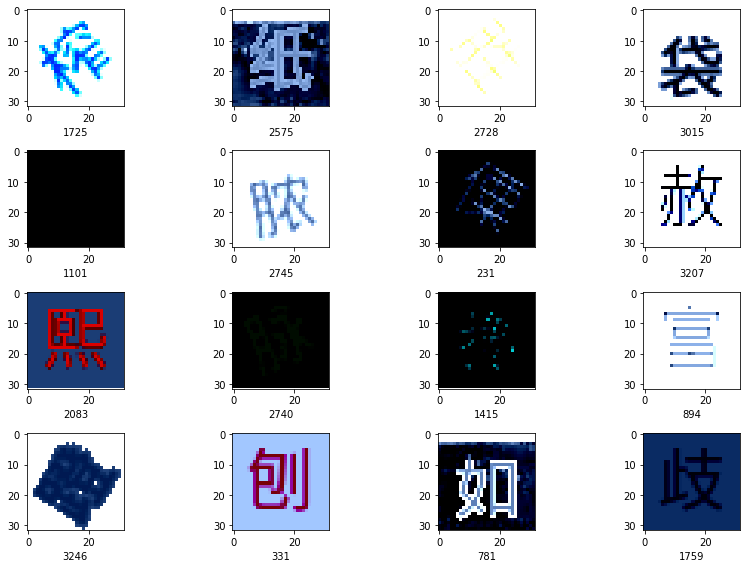

In [32]:
show_batch(image.permute([0,2,3,1]), target.numpy(), (4,4))

In [33]:
"".join([index2char[item] for item in target.numpy()])[:16]

'榨纸胜袋徐脓僳赦熙脉搀富蹬刨如歧'

## Model

In [34]:
base_model = torchvision.models.resnet34(pretrained=True)
for index, (name, layer) in enumerate(base_model.named_children()):
    print(index, name, " -> ", layer)
    print("--"* 40)

0 conv1  ->  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
--------------------------------------------------------------------------------
1 bn1  ->  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
--------------------------------------------------------------------------------
2 relu  ->  ReLU(inplace=True)
--------------------------------------------------------------------------------
3 maxpool  ->  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
--------------------------------------------------------------------------------
4 layer1  ->  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64

In [35]:
class Model(nn.Module):
    def __init__(self, n_classes):
        super(Model, self).__init__()
        
        self.head = torch.nn.Sequential(
            torch.nn.Conv2d(3,64,kernel_size=(1,1),stride=(1,1),padding=(0,0),bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True)
        )
        
        base_model = torchvision.models.resnet34(pretrained=True)
#         for param in base_model.parameters():
#             param.requires_grad = False 

        base_model_layers = list(base_model.children()) 
        self.body = torch.nn.Sequential(*base_model_layers[4:9])
        
        
        self.fc = torch.nn.Linear(in_features=512, out_features=n_classes, bias = True)
    
    
    def forward(self, x):
        x = self.head(x)
        x = self.body(x)
        x = x.view(-1, x.shape[1])
        logits = self.fc(x)
        probas = F.softmax(logits, dim = 1)
        return logits,probas

In [36]:
model = Model(n_classes = len(index2char))
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=1,
        threshold=0.01,
        factor = 0.2,
        verbose=True,
        mode="max")

In [37]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             192
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [38]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    valid_acc_list = []
    best_valid_acc = 0
    
    for epoch in range(num_epochs):
        start = time.time()
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)
            
            _, predicted_labels = torch.max(probas, 1)
            correct_pred = (predicted_labels == targets).sum()
            train_acc = correct_pred.float() / target.size(0) * 100
            
            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
            
            if batch_idx % 50 == 0:
                
                print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.3f} | Acc: {5:.3f}'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss, train_acc))
        
        end = time.time()
        with torch.set_grad_enabled(False):
            
            valid_acc = metric_func(model, data_loader["val"], device)
            
            print('Epoch: {0:03d}/{1:03d} | val acc: {2:.3f} % | time: {3:.3f} s'.format(
                  epoch+1, num_epochs, valid_acc, end-start))
            
            if not os.path.exists("ocr_model_checkpoint"):
                os.mkdir("ocr_model_checkpoint")
            
            if best_valid_acc <= valid_acc:
                best_valid_acc = valid_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'valid_roc': valid_acc,
                    'optimizer_state_dict': optimizer.state_dict(),
                }, "ocr_model_checkpoint/best_model.pt")
            
    
            valid_acc_list.append(valid_acc)
        
        scheduler.step(valid_acc)
            
    checkpoint = torch.load("ocr_model_checkpoint/best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
            
    return model, loss_list, valid_acc_list

In [ ]:
model, loss_list, valid_acc_list = train_model(model, 
            dataset_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_accuracy)

Epoch: 001/010 | Batch 000/9387 | Loss: 8.859 | Acc: 0.000
Epoch: 001/010 | Batch 050/9387 | Loss: 8.528 | Acc: 0.000
Epoch: 001/010 | Batch 100/9387 | Loss: 8.672 | Acc: 0.000
Epoch: 001/010 | Batch 150/9387 | Loss: 8.374 | Acc: 0.000
Epoch: 001/010 | Batch 200/9387 | Loss: 8.568 | Acc: 0.000
Epoch: 001/010 | Batch 250/9387 | Loss: 8.351 | Acc: 0.000
Epoch: 001/010 | Batch 300/9387 | Loss: 8.468 | Acc: 0.000
Epoch: 001/010 | Batch 350/9387 | Loss: 8.338 | Acc: 0.000
Epoch: 001/010 | Batch 400/9387 | Loss: 8.479 | Acc: 0.000
Epoch: 001/010 | Batch 450/9387 | Loss: 8.335 | Acc: 0.000
Epoch: 001/010 | Batch 500/9387 | Loss: 8.457 | Acc: 0.000
Epoch: 001/010 | Batch 550/9387 | Loss: 8.301 | Acc: 0.000
Epoch: 001/010 | Batch 600/9387 | Loss: 8.266 | Acc: 0.000
Epoch: 001/010 | Batch 650/9387 | Loss: 8.256 | Acc: 0.000
Epoch: 001/010 | Batch 700/9387 | Loss: 8.356 | Acc: 0.000
Epoch: 001/010 | Batch 750/9387 | Loss: 8.346 | Acc: 0.000
Epoch: 001/010 | Batch 800/9387 | Loss: 8.379 | Acc: 0.0

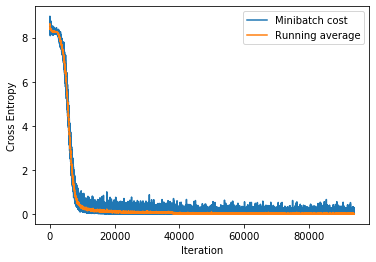

In [21]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(30,)/30, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

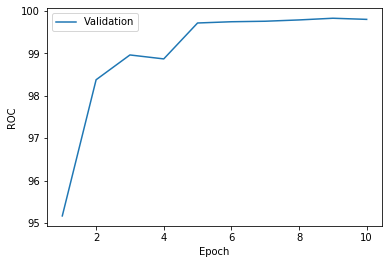

In [22]:
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()
plt.show()

In [47]:
test_transforms = A.Compose([
                        A.Resize(32,32),
                        A.ToGray(),
                        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                        ToTensor()
                    ])


class TycOCRTestDataset(Dataset):
      
    def __init__(self, root, index2char, transforms = None):

        self.samples = []
        self.labels = []
        self.index2char = index2char
        
        self.char2index = {val:key for key,val in index2char.items()}
        
        self.transforms = transforms

        for direc in root.glob("*"):
            if direc.is_dir():
                source = direc / "0"
                target = direc / "1"

                target_set = set()

#                 for s_char in source.glob("*.png"):
#                     char = s_char.name[0]
#                     self.samples.append(s_char)
#                     self.labels.append( self.char2index.get(char,-1) )
                      
                for t_char in target.glob("*.png"):
                    char = t_char.name[0]
                    self.samples.append(t_char)
                    self.labels.append(self.char2index.get(char,-1))
                    

    def __getitem__(self, index):

        img = self.samples[index]
        target = self.labels[index]        
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        img = self.transforms(image = img)["image"]

        return img,torch.tensor(target)
    
    def __len__(self):
        return len(self.samples)
    
    
    
test_dataset = TycOCRTestDataset(Path("tycOCR/data"), index2char, transforms = test_transforms )
test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=True)

In [68]:
checkpoint = torch.load("ocr_model_checkpoint/best_model.pt")
model.load_state_dict(checkpoint["model_state_dict"])
compute_accuracy(model, dataset_loader["val"], DEVICE)

tensor(99.1904, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

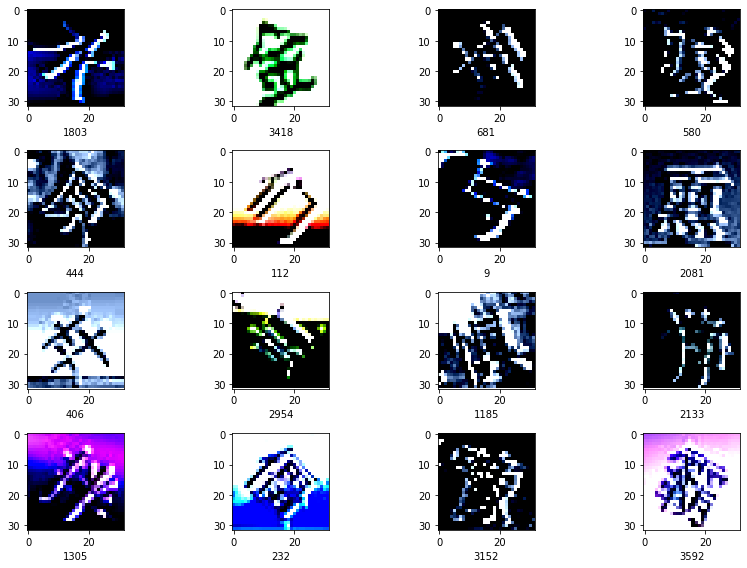

In [49]:
image, target = next(iter(test_dataloader))
show_batch(image.permute([0,2,3,1]), target.numpy(), (4,4))

In [50]:
model.eval()
all_preds = []
all_targets = []

for i, (features,targets) in enumerate(test_dataloader):
    features = features.to(DEVICE)
    logits,probas = model(features)
    _, predicted_labels = torch.max(probas, 1)
    all_preds += predicted_labels.tolist()
    all_targets += targets.tolist()

In [51]:
np.mean(np.array(all_preds) == np.array(all_targets))

0.2657629255989912

In [83]:
"".join([index2char.get(index,-1) for index in all_preds])

'书足录式睦叼吵杂纯吐零躁阐毫宋卫津卫等皂咐易帛土墨书蛊具哗遮耐鸳吭贮靡'